In [81]:
from selenium import webdriver
import time
import re
import numpy as np
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

driver = webdriver.Chrome(executable_path=r"C:\Users\Rohan Garg\Desktop\Isha Master File\chrome driver\chromedriver.exe")
driver

<selenium.webdriver.chrome.webdriver.WebDriver (session="e228b8856a71290039b85dcccbc6292b")>

In [82]:
##login into instagram account
def login_account(username, password) :
    driver.get('https://www.instagram.com/?hl=en')
    
    time.sleep(3)
    
    #To fill in username : first find it and then enter values
    user = driver.find_element_by_name('username')
    user.send_keys(username)

    #Finding and then filling the password tab
    passw = driver.find_element_by_name('password')
    passw.send_keys(password)

    #Finding submit button
    button = driver.find_element_by_xpath('//button/div')
    button.click()

    time.sleep(5)

    pop_up = driver.find_elements_by_xpath('//div[contains(@class, "mt3GC")]/button')[-1]
    pop_up.click()
    
login_account('SAMPLE USERNAME', 'SAMPLE PASSWORD')

In [118]:
#Ques 1, 1)

def find_followers(username) :
    driver.get('https://www.instagram.com/'+ username+'/')
    
    num_followers = driver.find_elements_by_class_name('g47SY ')[1].text
    if num_followers.find('.') != -1 :
        l = num_followers.split('.')
        last_char = l[-1][-1]
        zeroes = ''
        if last_char == 'k' :
            zeroes = l[-1][0]+'00'
        elif last_char == 'm' :
            zeroes = l[-1][0]+'00000'
        num_followers = l[0] + zeroes

    elif num_followers.find(',') != -1 :
        l = num_followers.split(',')
        num_followers = l[0]+l[1]

    else :
        last_char = num_followers[-1]
        num = re.search('\d+', num_followers).group()
        zeroes = ''
        if last_char == 'k' :
            zeroes = '000'
        elif last_char == 'm' :
            zeroes = '000000'    
        num_followers = num + zeroes
    
    return int(num_followers)


def top_5_highest_followers (search_name) :
    search = driver.find_element_by_xpath('//input[@placeholder = "Search"]')
    search.send_keys(search_name)
    
    time.sleep(1)
    
    food_accounts=[]
    resp_followers=[]
    count=0
    
    handles = driver.find_elements_by_class_name('Ap253')
    for i in handles :
        if count > 10 :
            break
        f = i.text
        if '#' not in f and ',' not in f:
            food_accounts.append(f)
            
        count += 1
    
    for i in range(10) :
        resp_followers.append(find_followers(food_accounts[i]))
    
    np_followers = np.array(resp_followers)
    np_handles = np.array(food_accounts)
    
    np_handles = np_handles[np_followers.argsort()]
    np_followers.sort()
    
    np_handles = np_handles[::-1]
    np_followers = np_followers[::-1]
    
    d = dict()
    for i in range(5) :
        d[np_handles[i]] = np_followers[i]

    return d

followers_dict = dict()
followers_dict = top_5_highest_followers('food')
followers_dict

{'foodnetwork': 10300000,
 'buzzfeedfood': 3700000,
 'dilsefoodie': 447000,
 'foodtalkindia': 295000,
 'food': 30000}

In [130]:
#Ques 1, 2)

food_handles = []
for i in followers_dict :
    food_handles.append(i)

def last3days_posts (username) :
    driver.get('https://www.instagram.com/'+ username+'/')
    time.sleep(1)
    driver.find_element_by_xpath('//div[contains(@class, "eLAPa")]').click()   ##To open the first post
    
    post_count = 0
    to_include = True
    
    while to_include :
        time.sleep(2)
        t = driver.find_element_by_xpath('//a[contains(@class, "c-Yi7")]/time').text
        if t.find('HOURS') != -1 or t.find('HOUR') != -1 :
            to_include = True     ## Because instagram shows hours upto 24 so they will be included
            post_count += 1
        elif t.find('MINUTE') != -1 or t.find('MINUTES') != -1:
            to_include = True
            post_count += 1
        elif t.find('DAY') != -1 or t.find('DAYS') != -1 :
            num = re.search('\d', t).group()
            if int(num) < 4 :    ## I have also included the '3 days ago' posts
                to_include = True
                post_count += 1
            else :
                to_include = False
        else :
            to_include = False
            
        driver.find_elements_by_xpath('//div[contains(@class, "DdSX2")]/a')[-1].click()  ##To click on next post
        time.sleep(2)
            
    return post_count

posts_dict = dict()
for i in range(5) :
    count = last3days_posts(food_handles[i])
    posts_dict[food_handles[i]] = count

posts_dict

{'foodnetwork': 39,
 'buzzfeedfood': 0,
 'dilsefoodie': 2,
 'foodtalkindia': 8,
 'food': 6}

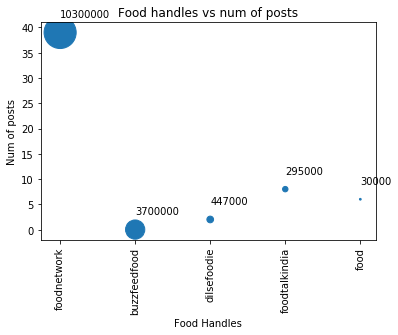

In [272]:
#Ques 1, 3)
import matplotlib.pyplot as plt

handle_names=[]
follower_count=[]
post_count=[]
for i in followers_dict :
    handle_names.append(i)
    follower_count.append(followers_dict[i])
    
for i in posts_dict :
    post_count.append(posts_dict[i])

np_follower_count = np.array(follower_count)
np_follower_count = np_follower_count/10000
plt.scatter(handle_names, post_count, s = np_follower_count)
plt.title('Food handles vs num of posts')
plt.xticks(rotation=90)
for i in range(5) :
    plt.text(handle_names[i], post_count[i]+3, follower_count[i])
plt.grid()
plt.xlabel('Food Handles')
plt.ylabel('Num of posts')
plt.grid()
plt.show()

In [218]:
#Ques 2, 1,2)

def scrape_content(username) :
    driver.get('https://www.instagram.com/'+ username+'/')
    time.sleep(1)
    driver.find_element_by_xpath('//div[contains(@class, "eLAPa")]').click()   ##To open the first post
    time.sleep(1)
    
    tagged_people=[]
    hashtags=[]
    content=[]
    cl=''
    hl=''
    for i in range(10) :
        try :
            driver.find_element_by_xpath('//div[contains(@class, "C4VMK")]/h2/div/a')
            if driver.find_elements_by_xpath('//div[contains(@class, "C4VMK")]/h2/div/a')[0].text == username :
                cl = driver.find_element_by_xpath('//div[contains(@class, "C4VMK")]/span').text.split() ##caption content

            time.sleep(1)

            if driver.find_elements_by_xpath('//div[contains(@class, "C4VMK")]/span')[1].text == username :
                hl = driver.find_element_by_xpath('//div[contains(@class, "C4VMK")]/span').text.split() ## for cases in 
                ## which people comment and use hashtags 

            for i in range(len(cl)) :
                if '#' in cl[i] :
                    hashtags.append(cl[i])
                elif '@' in cl[i] :
                    tagged_people.append(cl[i])
                else :
                    content.append(cl[i])

            for i in range(len(hl)) :
                hashtags.append(hl[i])
                
        except :
            EC.NoSuchElementException

        driver.find_elements_by_xpath('//div[contains(@class, "DdSX2")]/a')[-1].click()  ##To click on next post
        time.sleep(2)
    
    return tagged_people, hashtags, content

tagged={}
hashtags={}
other_words={}
t=[]
h=[]
c=[]
for j in range(5) :
    t, h, c = scrape_content(food_handles[j])
    
    for i in t :
        if i in tagged :
            tagged[i] += 1
        else :
            tagged[i] = 1
    for i in h :
        if i in hashtags :
            hashtags[i] += 1
        else :
            hashtags[i] = 1    
    for i in c :
        if i in other_words :
            other_words[i] += 1
        else :
            other_words[i] = 1  


print(other_words)

{'Summertime': 1, 'Sunshine': 1, 'Cake': 2, '☀️': 1, 'Bring': 1, 'summertime': 1, 'inside': 1, 'with': 24, 'this': 9, 'incredible': 1, 'sunshine-inspired': 1, 'cake!': 1, 'Incredible': 1, 'work,': 1, '👏': 1, "Don't": 1, 'miss': 2, 'the': 60, 'season': 2, 'finale': 1, 'of': 26, '>': 4, 'Tonight': 2, 'at': 15, '9|8c': 3, 'The': 1, 'Perfect': 1, 'Strawberry': 3, 'Pie': 1, '🥧': 1, "Now's": 1, 'THE': 1, 'time': 3, 'to': 32, 'make': 3, 'Pie!': 1, '🍓🍓': 1, 'And': 6, 'you': 16, 'can': 4, 'use': 2, 'store-bought': 1, 'crust,': 1, 'too!': 1, 'Catch': 2, 'a': 30, 'marathon': 1, 'your': 15, 'favorite': 2, 'episodes': 2, 'coming': 1, 'up': 6, '10a|9c': 1, 'today.': 1, 'Save': 2, 'recipe': 7, 'on': 20, 'app.': 2, 'Class': 1, 'Day:': 2, 'Kale': 1, 'Lemon-Pepper': 1, 'Chicken': 4, '🍋': 1, 'This': 5, 'one-pan': 1, 'meal': 2, 'is': 14, 'packed': 1, 'kale,': 1, 'chicken': 4, 'and': 45, 'Brussels': 1, 'sprouts,': 1, "it's": 1, 'cinch': 1, 'pull': 1, 'together': 2, 'any': 1, 'night': 1, 'week!': 1, 'shares

In [274]:
#Ques 2, 3)
import pandas as pd

def csv_file (dictionary, name) :
    word_freq=[]
    for i in dictionary :
        word_freq.append([i,dictionary[i]])   
        
    df = pd.DataFrame(word_freq, columns=['Words', 'Frequency'])
    df.to_csv(name)

csv_file(other_words, 'food_word_freq.csv')

In [230]:
#Ques 2, 4)

def most_popular_hashtags (dictionary) :
    hashtags=[]
    freq=[]
    for i in dictionary :
        hashtags.append(i)
        freq.append(dictionary[i])
        
    np_hashtags = np.array(hashtags)
    np_freq = np.array(freq)
    
    np_hashtags = np_hashtags[np_freq.argsort()]
    np_freq.sort()
    
    np_hashtags = np_hashtags[::-1]
    np_freq = np_freq[::-1]
    
    for i in range(10) :
        print(np_hashtags[i], np_freq[i])  ##Printing top 10 most used hashtags 
    
    return np_hashtags, np_freq

ha=[]
fr=[]
ha, fr = most_popular_hashtags(hashtags)

#dilsefoodie 10
#food 8
#yum 7
#WeCook 3
#WorstCooks 3
#homemade 3
#breakfast 2
#baking 2
#odisha 2
#denver 2


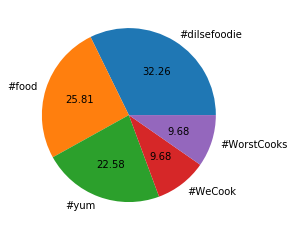

In [232]:
#Ques 2, 5)

def pie_graph (hl, fl) :
    hl = hl[:5]
    fl = fl[:5]
    
    plt.pie(fl, labels = hl, autopct = '%.2f')
    plt.show()
    
pie_graph(ha, fr)

In [264]:
#Ques 3, 1,2,3)

def average_followers (username, n) :
    driver.get('https://www.instagram.com/'+ username+'/')
    time.sleep(1)
    driver.find_element_by_xpath('//div[contains(@class, "eLAPa")]').click()   ##To open the first post
    time.sleep(1)
    
    num_followers = follower_count[n]   ##already obtained follower count hence extracting from their
    handle_likes=[]
    for i in range(10) :
        try :
            driver.find_element_by_xpath('//div[contains(@class, "Nm9Fw")]/button')  #If likes is not present then it's a video
            likes = driver.find_element_by_xpath('//div[contains(@class, "Nm9Fw")]/button').text
            likes = likes.split(' ')[0]
            if likes.find(',') != -1 :
                likes = likes.split(',')
                likes = likes[0]+likes[1]
            handle_likes.append(int(likes))
            
        except NoSuchElementException :
            driver.find_element_by_class_name('vcOH2').click()  #to view likes for that video
            likes = driver.find_element_by_class_name('vJRqr').text
            likes = likes.split(' ')[0]
            if likes.find(',') != -1 :
                likes = likes.split(',')
                likes = likes[0]+likes[1]
            handle_likes.append(int(likes))
            driver.find_element_by_class_name('QhbhU').click()  ##To exit that otherwise next button won't be clickable
            
        driver.find_elements_by_xpath('//div[contains(@class, "DdSX2")]/a')[-1].click()  ##To click on next post
        time.sleep(2)
        
    summ = 0
    for i in range(10) :
        summ = summ + handle_likes[i]
    
    avg_likes = summ/10
    avg_follower = num_followers/avg_likes
    
    return avg_follower

avg_follower_list=[]
for i in range(5) :
    average_f = average_followers(food_handles[i], i)
    avg_follower_list.append(average_f)

print(food_handles, avg_follower_list)

['foodnetwork', 'buzzfeedfood', 'dilsefoodie', 'foodtalkindia', 'food'] [795.9199443628777, 649.4190332432338, 59.02314710892213, 395.33637094612703, 39.10323253388947]


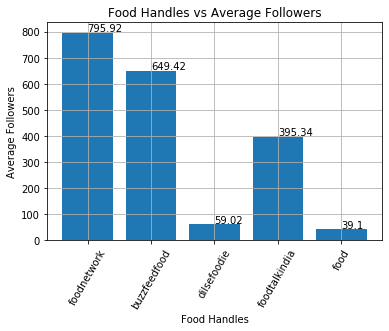

In [271]:
#Ques 3, 4)

plt.bar(food_handles, avg_follower_list)
plt.title('Food Handles vs Average Followers')
plt.xlabel('Food Handles')
plt.xticks(rotation=60)
plt.ylabel('Average Followers')
for i in range(5) :
    plt.text(food_handles[i], avg_follower_list[i]+5, round(avg_follower_list[i], 2))
plt.grid()
plt.show()